In [1]:
import torch
import json
import numpy
from sklearn.preprocessing import MinMaxScaler
import shap
import sys
import time
import pandas as pd
import os
import re

In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [3]:
def load_dataset(path, dataset):
    with open(path + dataset + "_TRAIN.npy", 'rb') as f:
        train = numpy.load(f, allow_pickle=True)
    print("Train shape:", train.shape)
    with open(path + dataset + "_TEST.npy", 'rb') as f:
        test = numpy.load(f, allow_pickle=True)
    print("Test shape:", test.shape)
    #scaling
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train.reshape(-1,train.shape[-1])).reshape(train.shape)
    test = scaler.fit_transform(test.reshape(-1,test.shape[-1])).reshape(test.shape)
    return train, test

In [4]:
def load_cluster_labels(path, cluster_labels):
    print("Silhouette Score:", cluster_labels.split('SilhouetteScore_')[1].split('_')[0])
    cluster_labels = numpy.load(path + cluster_labels)
    print("Number of clusters:", len(set(cluster_labels)))
    print("Clusters:", set(cluster_labels))
    print("Cluster Labels:",cluster_labels)
    return cluster_labels

In [5]:
def get_data_per_cluster(cluster_indices, data, print_=False):
    cluster_data = numpy.array([])
    count = 0
    for i in cluster_indices:
        sample = data[i].reshape(1, data.shape[1])
        # reshape to (x, 1)
        sample = sample.reshape(1, sample.shape[1])
        if print_:
            print(sample.shape)
        if count == 0:
            cluster_data = sample
        else:
            cluster_data = numpy.append(cluster_data, sample, axis=0) 
        count = count + 1
    if print_:
        print(cluster_data.shape)
    return cluster_data

In [6]:
def get_anomaly_cluster_association(cluster_labels, cluster):
    # get position (index) of each anomaly belonging to a cluster
    cluster_indices = [index for index, value in enumerate(cluster_labels) if value == cluster]
    print(len(cluster_indices),"samples in cluster", cluster)
    return cluster_indices

In [7]:
def get_plots_per_sample_within_cluster(cluster_indices, shap_values, sample_values, features):
    for i in cluster_indices:
        print("Sample:",i)
        shap_values_sample = shap_values[i].reshape(1, shap_values.shape[1])
        sample = sample_values[i].reshape(1, sample_values.shape[1])
        shap.summary_plot(shap_values_sample, sample, feature_names=features, max_display=20)

## Features

In [8]:
df = pd.read_csv("/home/sto2/storage_data/df_actualAnomalies_reducedFeatures_sergeValidated.csv")
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.drop(['systemid','instanceid'], axis=1, inplace=True)
features = df.columns[2:].to_list()

source_path = "/home/sto2/0-final_storageData_arrays/"
all_files = os.listdir(source_path)
counter = 1
features_order_in_data = []
for file in sorted(all_files):
    dimension_number = int(re.findall(r'\d+', file)[0])
    print(file, features[dimension_number-1])
    features_order_in_data.append(features[dimension_number-1])
    counter+=1

df_actualAnomalies_reducedFeatures_sergeValidatedDimension1.npy Read Cache Hits - VCC (%)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension10.npy Overall Back-end Response Time (ms/op)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension11.npy Back-end Read Queue Time (ms/op)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension12.npy Back-end Write Queue Time (ms/op)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension13.npy Back-end Read Transfer Size (KiB/op)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension14.npy Back-end Write Transfer Size (KiB/op)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension15.npy Read I/O Rate - overall (ops/s)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension16.npy Write I/O Rate - overall (ops/s)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension17.npy Peak Back-end Read Response Time (ms)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension18.npy Port Send Data Rate (MiB/s)
df_actualAnom

In [9]:
features_order_in_data

['Read Cache Hits - VCC (%)',
 'Overall Back-end Response Time (ms/op)',
 'Back-end Read Queue Time (ms/op)',
 'Back-end Write Queue Time (ms/op)',
 'Back-end Read Transfer Size (KiB/op)',
 'Back-end Write Transfer Size (KiB/op)',
 'Read I/O Rate - overall (ops/s)',
 'Write I/O Rate - overall (ops/s)',
 'Peak Back-end Read Response Time (ms)',
 'Port Send Data Rate (MiB/s)',
 'Write Data Rate (MiB/s)',
 'Read Cache Hits - VC (%)',
 'Read Response Time (ms/op)',
 'Write Response Time (ms/op)',
 'Port Receive Data Rate (MiB/s)',
 'Overall Response Time (ms/op)',
 'Read Transfer Size (KiB/op)',
 'Write Transfer Size (KiB/op)',
 'Port Send I/O Rate (ops/s)',
 'Total Cache Hits - VCC (%)',
 'Total Cache Hits - VC (%)',
 'Port to Host Send I/O Rate (ops/s)',
 'Write Cache Hits - VCC (%)',
 'Port to Disk Send I/O Rate (ops/s)',
 'Port to Disk Receive I/O Rate (ops/s)',
 'Port to Local Node Send I/O Rate (ops/s)',
 'Port to Remote Node Send I/O Rate (ops/s)',
 'Port to Disk Send Data Rate (MiB

## Paths

In [10]:
data_path = '/home/sto/Data/0-actualAnomalies_reducedFeatures_sergeValidated_ZERO/'
dataset = '0-df_actualAnomalies_reducedFeatures_sergeValidated'

In [11]:
shap_values_path = '/home/sto/Data/0-SHAP/00wholeSet_clustersSeparated_May3/cluster_1_10_samples_noResponseTime/'

In [12]:
cluster_indices_path = '0-SHAP_cluster_1_10_samples_NORESPONSETIME_silhouetteScore_0.8633223762692354_MAY03Results.npy'

## Dataset

In [13]:
train, test = load_dataset(data_path, dataset)

Train shape: (66, 84, 1113)
Test shape: (17, 84, 1113)


In [14]:
dataset = numpy.concatenate((train,test))
print(dataset.shape)

(83, 84, 1113)


In [15]:
number_anomalies = dataset.shape[0]
number_anomalies

83

## Shap Values

In [16]:
all_files = os.listdir(shap_values_path)
all_files.sort(key=natural_keys)
shap_values = []
for file in all_files:
    if 'shap-values' in file:
        print(file)
        array = numpy.load(shap_values_path + file)
        shap_values.append(array)
print(len(shap_values))

shap-values_all-anomalies_samples-to-explain_10_CLUSTER_background-data_9_noResponseTime_Anomaly__31Cluster_.npy
shap-values_all-anomalies_samples-to-explain_10_CLUSTER_background-data_9_noResponseTime_Anomaly__43Cluster_.npy
shap-values_all-anomalies_samples-to-explain_10_CLUSTER_background-data_9_noResponseTime_Anomaly__66Cluster_.npy
shap-values_all-anomalies_samples-to-explain_10_CLUSTER_background-data_9_noResponseTime_Anomaly__71Cluster_.npy
shap-values_all-anomalies_samples-to-explain_10_CLUSTER_background-data_9_noResponseTime_Anomaly__73Cluster_.npy
shap-values_all-anomalies_samples-to-explain_10_CLUSTER_background-data_9_noResponseTime_Anomaly__75Cluster_.npy
shap-values_all-anomalies_samples-to-explain_10_CLUSTER_background-data_9_noResponseTime_Anomaly__77Cluster_.npy
shap-values_all-anomalies_samples-to-explain_10_CLUSTER_background-data_9_noResponseTime_Anomaly__79Cluster_.npy
shap-values_all-anomalies_samples-to-explain_10_CLUSTER_background-data_9_noResponseTime_Anomaly

In [17]:
shap_values = numpy.concatenate(shap_values, axis=0 )
print(shap_values.shape)
print(shap_values)

(10, 84, 1113)
[[[-3.24514293e-08 -6.72050636e-10 -5.14774167e-08 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 4.28428649e-06  7.37979969e-07  2.59126871e-06 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-4.68642216e-10 -5.05592919e-13 -1.92502028e-10 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [-2.84816164e-07 -1.82891743e-08 -2.60467908e-07 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-5.03610739e-08  2.64853489e-07  1.75212470e-06 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-6.00717704e-08 -8.20427919e-09 -7.29076407e-08 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-3.24352853e-08 -3.76361944e-09 -5.27137626e-08 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 4.28436985e-06  2.44334870e-07  2.62045719e-06 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-4.71903881e-10 -2.80879585e-13 -1.92502028e-10 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [-2.84

## Lengths of Anomalies

In [18]:
cluster_indices = numpy.load(cluster_indices_path)
cluster_indices

array([31, 43, 66, 71, 73, 75, 77, 79, 81, 82])

In [19]:
anomalies_length = numpy.load("/home/sto/Data/0-actualAnomalies_reducedFeatures_sergeValidated/anomalies_length.npy")
cluster_anomalies_length = []
for i in cluster_indices:
    cluster_anomalies_length.append(anomalies_length[i])
print(len(cluster_anomalies_length))
print(cluster_anomalies_length)

10
[631, 849, 297, 489, 469, 666, 480, 272, 449, 335]


In [20]:
print(numpy.amin(cluster_anomalies_length))
print(numpy.amax(cluster_anomalies_length))

272
849


## Cut Shap Values to Lengths of Anomalies

In [21]:
new_shap_values = []
for i in range(0,10):
    feature_array = []
    length = cluster_anomalies_length[i]
    print("Anomaly #", i+1, "Length:", length)
    for x in range(0,84):
        print("Dimensions #",x+1)
        print(shap_values[i][x])
        print(shap_values[i][x].shape[0])
        new_anomaly = shap_values[i][x][:length]
        print(new_anomaly.shape[0])
        val_pad = 1113 - new_anomaly.shape[0]
        if val_pad != 0:
            new_anomaly = numpy.pad(new_anomaly, (0, val_pad), 'constant', constant_values=(numpy.nan))
        feature_array.append(new_anomaly)
    new_shap_values.append(feature_array)
    print("#####################################################")
new_shap_values = numpy.array(new_shap_values)

Anomaly # 1 Length: 631
Dimensions # 1
[-3.24514293e-08 -6.72050636e-10 -5.14774167e-08 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
631
Dimensions # 2
[4.28428649e-06 7.37979969e-07 2.59126871e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
631
Dimensions # 3
[-4.68642216e-10 -5.05592919e-13 -1.92502028e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
631
Dimensions # 4
[-5.48586008e-11 -1.18376606e-10  3.51526211e-09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
631
Dimensions # 5
[2.58167282e-05 3.13504699e-06 2.76127723e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
631
Dimensions # 6
[-1.05621536e-05 -4.09469705e-07 -1.43482825e-05 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
631
Dimensions # 7
[-8.22701962e-04 -7.31955567e-06 -1.80317558e-03 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
631
Dimensions # 8
[ 1.39565841e-04  4.98121799e-05 -5.88982744e-05 ...  0.00000000e+00
  0.00000000e+0

297
Dimensions # 43
[-1.83906977e-06  3.81590497e-07 -2.25639543e-06 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
297
Dimensions # 44
[-2.34140439e-12 -2.22305832e-01 -1.78273515e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
297
Dimensions # 45
[-5.42585065e-05  1.69405848e-07 -4.81990356e-05 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
297
Dimensions # 46
[0. 0. 0. ... 0. 0. 0.]
1113
297
Dimensions # 47
[0. 0. 0. ... 0. 0. 0.]
1113
297
Dimensions # 48
[ 1.02198250e-09 -2.11466608e-08  0.00000000e+00 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
297
Dimensions # 49
[4.50891332e-09 1.22761104e-09 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
297
Dimensions # 50
[-5.62591108e-06 -1.18235477e-06 -3.12334173e-06 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
297
Dimensions # 51
[-1.57377960e-08 -1.11694952e-08 -6.72974109e-08 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
297
Dimensio

  0.00000000e+00  0.00000000e+00]
1113
666
Dimensions # 25
[0. 0. 0. ... 0. 0. 0.]
1113
666
Dimensions # 26
[1.88664983e-04 1.50519567e-05 6.64367682e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
666
Dimensions # 27
[-4.26608177e-04  1.21616572e-06 -3.71582215e-04 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
666
Dimensions # 28
[1.26198221e-05 5.56081694e-08 6.42803447e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
666
Dimensions # 29
[1.26976704e-05 1.75424160e-07 1.68333407e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
666
Dimensions # 30
[2.55391760e-06 3.62503145e-07 2.39553111e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
666
Dimensions # 31
[ 9.81524280e-10 -4.96768303e-11 -9.32857961e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
666
Dimensions # 32
[0. 0. 0. ... 0. 0. 0.]
1113
666
Dimensions # 33
[2.52835117e-09 5.28746295e-10 5.08591636e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
11

  0.00000000e+00  0.00000000e+00]
1113
449
Dimensions # 7
[-8.27859161e-04 -7.14355555e-06 -1.79351997e-03 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
449
Dimensions # 8
[ 2.31237681e-05 -1.98274165e-06 -6.46655906e-05 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
449
Dimensions # 9
[-4.61445620e-06 -4.65048671e-08 -1.85732462e-05 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
449
Dimensions # 10
[3.35826729e-05 4.63513748e-06 3.05960014e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
449
Dimensions # 11
[7.53620066e-06 2.21111262e-06 1.45731968e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
449
Dimensions # 12
[2.49031566e-09 3.76399803e-09 1.44445568e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
449
Dimensions # 13
[-1.67836703e-08 -3.92917016e-09 -1.92604257e-08 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
449
Dimensions # 14
[-5.54587607e-10 -1.20137646e-08 -2.20291169e-09 ...  0.00000000e+

In [22]:
print(new_shap_values.shape)
print(new_shap_values)

(10, 84, 1113)
[[[-3.24514293e-08 -6.72050636e-10 -5.14774167e-08 ...             nan
               nan             nan]
  [ 4.28428649e-06  7.37979969e-07  2.59126871e-06 ...             nan
               nan             nan]
  [-4.68642216e-10 -5.05592919e-13 -1.92502028e-10 ...             nan
               nan             nan]
  ...
  [-2.84816164e-07 -1.82891743e-08 -2.60467908e-07 ...             nan
               nan             nan]
  [-5.03610739e-08  2.64853489e-07  1.75212470e-06 ...             nan
               nan             nan]
  [-6.00717704e-08 -8.20427919e-09 -7.29076407e-08 ...             nan
               nan             nan]]

 [[-3.24352853e-08 -3.76361944e-09 -5.27137626e-08 ...             nan
               nan             nan]
  [ 4.28436985e-06  2.44334870e-07  2.62045719e-06 ...             nan
               nan             nan]
  [-4.71903881e-10 -2.80879585e-13 -1.92502028e-10 ...             nan
               nan             nan]
  ...
  [-2.84

In [23]:
anomalies_length_new_array = []
for i in range(0,10):
    for x in range(0,84):
        # print(data[i][x])
        length = numpy.count_nonzero(~numpy.isnan(new_shap_values[i][x]))
        #print(length)
    anomalies_length_new_array.append(length)
print(len(anomalies_length_new_array))
print(anomalies_length_new_array)

10
[631, 849, 297, 489, 469, 666, 480, 272, 449, 335]


## Get Samples from dataset belonging to the Cluster

In [24]:
print(dataset.shape)
dataset_new_array = []
for i in cluster_indices:
    print(dataset[i].shape)
    dataset_new_array.append(dataset[i])
dataset_new_array = numpy.array(dataset_new_array)
print(dataset_new_array.shape)

(83, 84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(10, 84, 1113)


In [25]:
print(dataset_new_array.shape)
print(dataset_new_array)

(10, 84, 1113)
[[[1.79829656e-07 1.91489056e-05 1.24621795e-05 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [1.64702601e-08 1.17460820e-06 1.23423071e-06 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [4.82594613e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [2.55848701e-07 2.47528315e-05 1.22907164e-05 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [1.18330024e-07 1.12251212e-05 5.46254063e-06 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [1.74744663e-08 3.52152201e-06 1.32603174e-06 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[2.52298801e-07 3.68414236e-07 1.02726111e-05 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [1.54340729e-08 7.52313382e-06 6.73409870e-07 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 2.87823622e-10 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [2.55848701e-07 2.36015370e-05 1.21389792e-05 ... 0.00000000

In [26]:
dataset = dataset_new_array

## Cut Samples to Lengths of Anomalies

In [27]:
new_samples = []
for i in range(0,10):
    feature_array = []
    length = cluster_anomalies_length[i]
    print("Anomaly #", i+1, "Length:", length)
    for x in range(0,84):
        print("Dimensions #",x+1)
        print(dataset[i][x])
        print(dataset[i][x].shape[0])
        new_anomaly = dataset[i][x][:length]
        print(new_anomaly.shape[0])
        val_pad = 1113 - new_anomaly.shape[0]
        if val_pad != 0:
            new_anomaly = numpy.pad(new_anomaly, (0, val_pad), 'constant', constant_values=(numpy.nan))
        feature_array.append(new_anomaly)
    new_samples.append(feature_array)
    print("#####################################################")
new_samples = numpy.array(new_samples)

Anomaly # 1 Length: 631
Dimensions # 1
[1.79829656e-07 1.91489056e-05 1.24621795e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
631
Dimensions # 2
[1.64702601e-08 1.17460820e-06 1.23423071e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
631
Dimensions # 3
[4.82594613e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
631
Dimensions # 4
[3.03180711e-09 1.08797329e-07 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
631
Dimensions # 5
[1.60538664e-07 2.85100810e-05 1.65801764e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
631
Dimensions # 6
[4.37645194e-07 1.00798711e-05 5.52558745e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
631
Dimensions # 7
[7.56606653e-05 2.39900989e-04 2.08744921e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
631
Dimensions # 8
[3.61535322e-05 6.54309439e-05 4.47579336e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
631
Dimensio

 0.00000000e+00 0.00000000e+00]
1113
297
Dimensions # 74
[7.47366700e-05 1.47743904e-05 7.80750940e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
297
Dimensions # 75
[3.97038559e-05 6.92549552e-06 3.78545911e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
297
Dimensions # 76
[3.50328141e-05 6.92549552e-06 3.78545911e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
297
Dimensions # 77
[0. 0. 0. ... 0. 0. 0.]
1113
297
Dimensions # 78
[2.64380970e-06 1.03790093e-06 3.71448175e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
297
Dimensions # 79
[0. 0. 0. ... 0. 0. 0.]
1113
297
Dimensions # 80
[1.84506154e-04 3.64742764e-05 1.86907043e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
297
Dimensions # 81
[1.40131256e-04 2.95487809e-05 1.34856981e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
297
Dimensions # 82
[1.86841675e-04 3.69359761e-05 1.89272955e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
297
Dimensi

[0. 0. 0. ... 0. 0. 0.]
1113
666
Dimensions # 48
[0. 0. 0. ... 0. 0. 0.]
1113
666
Dimensions # 49
[0. 0. 0. ... 0. 0. 0.]
1113
666
Dimensions # 50
[2.27129411e-04 3.75500367e-05 2.32498166e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
666
Dimensions # 51
[7.98748161e-06 2.47978910e-05 5.86746161e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
666
Dimensions # 52
[0. 0. 0. ... 0. 0. 0.]
1113
666
Dimensions # 53
[0. 0. 0. ... 0. 0. 0.]
1113
666
Dimensions # 54
[0. 0. 0. ... 0. 0. 0.]
1113
666
Dimensions # 55
[0. 0. 0. ... 0. 0. 0.]
1113
666
Dimensions # 56
[3.43531775e-04 6.27911594e-07 9.11491234e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
666
Dimensions # 57
[0. 0. 0. ... 0. 0. 0.]
1113
666
Dimensions # 58
[0. 0. 0. ... 0. 0. 0.]
1113
666
Dimensions # 59
[0. 0. 0. ... 0. 0. 0.]
1113
666
Dimensions # 60
[1.38501063e-03 4.88385944e-05 1.61191946e-03 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
666
Dimensions # 61
[0.00000000e+00 6.2015

Dimensions # 33
[2.33552094e-08 4.61699701e-09 2.36591194e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
449
Dimensions # 34
[0.00066934 0.00034655 0.00021589 ... 0.         0.         0.        ]
1113
449
Dimensions # 35
[4.67104188e-08 9.23399403e-09 2.36591194e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
449
Dimensions # 36
[0. 0. 0. ... 0. 0. 0.]
1113
449
Dimensions # 37
[0. 0. 0. ... 0. 0. 0.]
1113
449
Dimensions # 38
[0. 0. 0. ... 0. 0. 0.]
1113
449
Dimensions # 39
[0.00090004 0.00015543 0.00081761 ... 0.         0.         0.        ]
1113
449
Dimensions # 40
[3.56400495e-05 1.48251774e-05 2.86511936e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
449
Dimensions # 41
[0. 0. 0. ... 0. 0. 0.]
1113
449
Dimensions # 42
[1.22264521e-04 1.38417570e-05 2.25234817e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
449
Dimensions # 43
[1.19574001e-03 1.45574378e-04 2.40140062e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
449


In [28]:
anomalies_length_new_array = []
for i in range(0,10):
    for x in range(0,84):
        # print(data[i][x])
        length = numpy.count_nonzero(~numpy.isnan(new_samples[i][x]))
        #print(length)
    anomalies_length_new_array.append(length)
print(len(anomalies_length_new_array))
print(anomalies_length_new_array)

10
[631, 849, 297, 489, 469, 666, 480, 272, 449, 335]


In [29]:
###############################################
dataset = new_samples
shap_values = new_shap_values
###############################################

## Weighted down: Zero Buffer Credit Timer

In [30]:
features_order_in_data[43]

'Zero Buffer Credit Timer (µs)'

In [31]:
for i in range(0,10):
    shap_values[i][43] = shap_values[i][43]/100

# Feature Explanations

In [32]:
shap_values_allTimesteps = numpy.nanmean(shap_values, axis=2)
print(shap_values_allTimesteps.shape)
print(shap_values_allTimesteps)

(10, 84)
[[-2.19057667e-04 -1.02874013e-05 -2.42983618e-11 -3.57608300e-09
  -8.58495035e-04 -3.67864371e-02 -1.06749222e-01 -3.07573220e-02
  -2.21602515e-02 -1.32288554e-03 -6.26718789e-04  1.79873855e-08
  -3.57357573e-06 -1.62232277e-05 -6.09722190e-04 -4.28125779e-06
  -7.48274607e-04 -7.49184218e-04 -6.09898040e-02 -2.95568871e-04
  -9.99195515e-05  0.00000000e+00 -4.26892202e-04 -1.71444340e-03
   0.00000000e+00 -1.25671230e-02 -3.30671432e-02 -1.33527406e-06
  -6.69474099e-06 -8.53002844e-07 -6.99576460e-09  1.99337711e-12
   1.16006645e-09 -1.11703524e-01  3.97196823e-09  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.34926572e-02 -2.05950199e-03
   0.00000000e+00 -3.28654035e-05 -2.92993626e-02 -3.87016181e-04
  -4.51979158e-03 -4.86766434e-13  3.03030091e-11 -9.33161191e-07
  -5.48750203e-07 -3.16690562e-04 -2.57449983e-05 -1.77756925e-10
  -1.92595070e-10  1.89585888e-10  0.00000000e+00 -2.50072487e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.23247531e-02
 

In [33]:
samples_allTimesteps = numpy.nanmean(dataset, axis=2)
print(samples_allTimesteps.shape)
print(samples_allTimesteps)

(10, 84)
[[1.21377872e-03 1.00651910e-04 2.39551903e-07 8.68829179e-07
  1.46865368e-03 3.06084397e-03 6.69617391e-02 2.06272678e-02
  7.42740180e-03 5.64518007e-03 9.95513871e-04 3.18096286e-08
  9.31063169e-05 1.04358740e-04 1.64991402e-03 9.01118079e-05
  1.17098031e-03 7.45854228e-04 4.38642307e-02 1.42063258e-03
  4.35088430e-04 0.00000000e+00 2.05483420e-03 5.79588204e-03
  0.00000000e+00 1.62950404e-02 2.17733087e-02 2.40921829e-04
  3.53045605e-04 3.05591291e-04 2.00512000e-05 7.50017063e-10
  2.75529691e-06 6.56003235e-02 3.65403938e-06 0.00000000e+00
  0.00000000e+00 0.00000000e+00 7.94392756e-03 9.21736261e-03
  0.00000000e+00 3.26913121e-04 9.01782410e-03 4.87849242e-02
  1.12077880e-02 1.13791227e-09 2.32171693e-08 3.24325892e-05
  1.01254581e-04 1.25942582e-03 2.00864848e-04 2.27894526e-09
  1.51849380e-07 3.82089241e-07 0.00000000e+00 4.94966671e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.36774246e-02
  2.71745570e-02 9.14341965e-03 7.72376218e-02 3.33851707e-02

In [34]:
cluster_indices

array([31, 43, 66, 71, 73, 75, 77, 79, 81, 82])

In [35]:
cluster_indices_to_cluster_data = []
for i in range(0,10):
    cluster_indices_to_cluster_data.append(i)
print(cluster_indices_to_cluster_data)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [36]:
cluster_shap_values = get_data_per_cluster(cluster_indices_to_cluster_data, shap_values_allTimesteps)
cluster_sample_values = get_data_per_cluster(cluster_indices_to_cluster_data, samples_allTimesteps)

In [37]:
average_cluster_shap_values = cluster_shap_values.mean(axis=0)
average_cluster_sample_values = cluster_sample_values.mean(axis=0)

In [38]:
average_cluster_shap_values = average_cluster_shap_values.reshape(1,average_cluster_shap_values.shape[0])
average_cluster_sample_values = average_cluster_sample_values.reshape(1,average_cluster_sample_values.shape[0])

## Cluster Plot Top 20

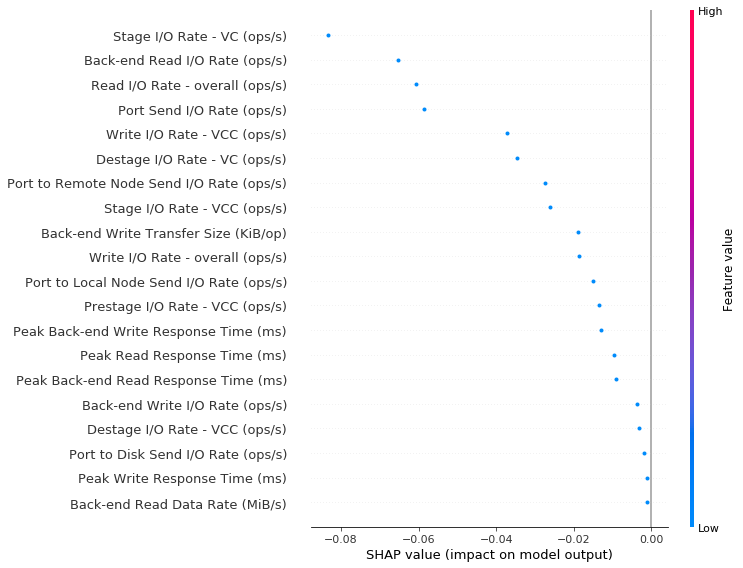

In [39]:
shap.summary_plot(average_cluster_shap_values, average_cluster_sample_values, feature_names=features_order_in_data, max_display=20)

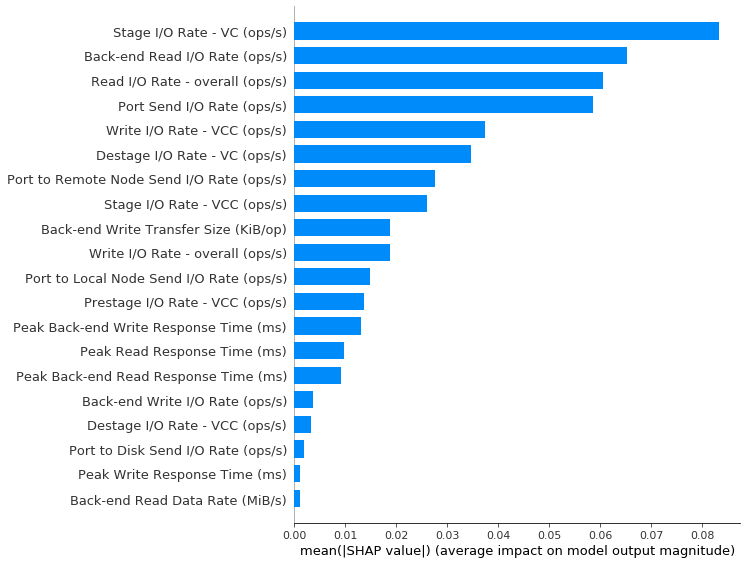

In [40]:
shap.summary_plot(average_cluster_shap_values, average_cluster_sample_values, feature_names=features_order_in_data, max_display=20, plot_type='bar')

## Cluster Plot Top 50

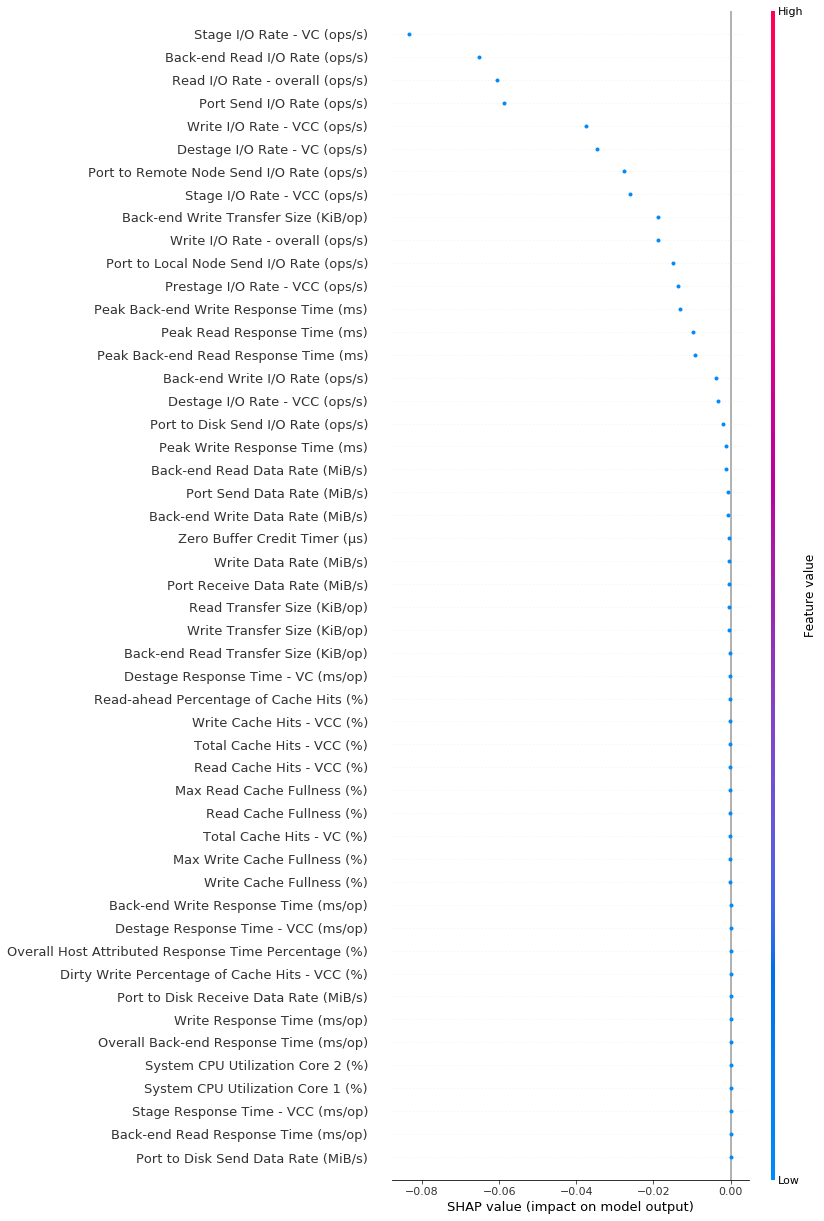

In [41]:
shap.summary_plot(average_cluster_shap_values, average_cluster_sample_values, feature_names=features_order_in_data, max_display=50)

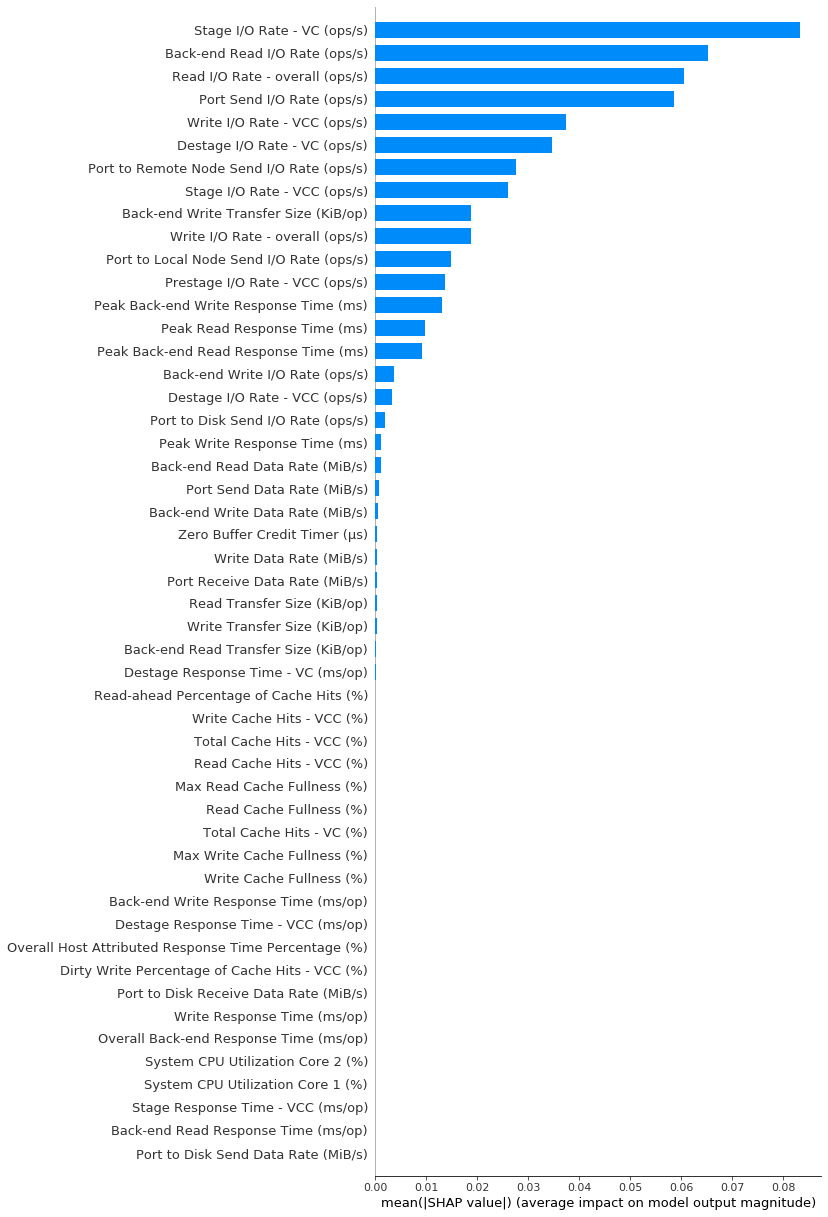

In [42]:
shap.summary_plot(average_cluster_shap_values, average_cluster_sample_values, feature_names=features_order_in_data, max_display=50, plot_type='bar')

# Temporal Explanations

In [43]:
shap_values_allFeatures = numpy.nanmean(shap_values, axis=1)
print(shap_values_allFeatures.shape)
print(shap_values_allFeatures)

(10, 1113)
[[-4.75994039e-05 -2.31831947e-05 -5.07486874e-05 ...             nan
              nan             nan]
 [-4.72667341e-05 -3.29666003e-05 -5.05776096e-05 ...             nan
              nan             nan]
 [-6.59649516e-05 -2.66308776e-05 -6.07631236e-05 ...             nan
              nan             nan]
 ...
 [-7.09977335e-05 -2.70524577e-05 -6.81707328e-05 ...             nan
              nan             nan]
 [-5.40250315e-05 -2.42669635e-05 -5.41659617e-05 ...             nan
              nan             nan]
 [-2.45305277e-04 -2.41982914e-05 -2.53220613e-04 ...             nan
              nan             nan]]


Mean of empty slice


## Categories

### Own Categories

### SME Categories

In [44]:
categories = pd.read_csv("grafana_tags.csv")
print(categories['entity'].unique())
print(categories['tag'].unique())

['StorageSystem' 'StoragePorts' 'Nodes' 'ManagedDisks' 'Volumes']
['Response Time Essential' 'Cause' 'Impact' 'Response Time Advanced'
 'Workload Basic' 'Front-end Basic']


In [45]:
impact = categories.loc[categories['tag'] == 'Impact']
impact = impact['metric'].tolist()
# check which of those features are in our feature list
impact = [i for i in impact if i in features_order_in_data]
impact

['Read Response Time (ms/op)',
 'Write Response Time (ms/op)',
 'Port to Local Node Send Response Time (ms/op)',
 'Port to Local Node Send Queue Time (ms/op)',
 'Port Send Delay I/O Percentage (%)',
 'Back-end Read Response Time (ms/op)',
 'Back-end Write Response Time (ms/op)',
 'Back-end Read Queue Time (ms/op)',
 'Back-end Write Queue Time (ms/op)',
 'Read Response Time (ms/op)',
 'Write Response Time (ms/op)']

In [46]:
cause = categories.loc[categories['tag'] == 'Cause']
cause = cause['metric'].tolist()
cause = [i for i in cause if i in features_order_in_data]
cause

['Read I/O Rate - overall (ops/s)',
 'Write I/O Rate - overall (ops/s)',
 'Write Data Rate (MiB/s)',
 'Read Transfer Size (KiB/op)',
 'Write Transfer Size (KiB/op)',
 'Peak Read Response Time (ms)',
 'Peak Write Response Time (ms)',
 'Back-end Read I/O Rate (ops/s)',
 'Back-end Write I/O Rate (ops/s)',
 'Back-end Read Data Rate (MiB/s)',
 'Back-end Write Data Rate (MiB/s)',
 'Back-end Read Transfer Size (KiB/op)',
 'Back-end Write Transfer Size (KiB/op)',
 'Peak Back-end Read Response Time (ms)',
 'Peak Back-end Write Response Time (ms)',
 'Read I/O Rate - overall (ops/s)',
 'Write I/O Rate - overall (ops/s)',
 'Write Data Rate (MiB/s)',
 'Read Transfer Size (KiB/op)',
 'Write Transfer Size (KiB/op)',
 'Peak Read Response Time (ms)',
 'Peak Write Response Time (ms)']

In [47]:
workload_basic = categories.loc[categories['tag'] == 'Workload Basic']
workload_basic = workload_basic['metric'].tolist()
workload_basic = [i for i in workload_basic if i in features_order_in_data]
workload_basic

['Back-end Read Data Rate (MiB/s)',
 'Back-end Read I/O Rate (ops/s)',
 'Back-end Read Response Time (ms/op)',
 'Back-end Write Data Rate (MiB/s)',
 'Back-end Write I/O Rate (ops/s)',
 'Back-end Write Response Time (ms/op)']

In [48]:
frontend_basic = categories.loc[categories['tag'] == 'Front-end Basic']
frontend_basic = frontend_basic['metric'].tolist()
frontend_basic = [i for i in frontend_basic if i in features_order_in_data]
frontend_basic

['Destage Response Time - VC (ms/op)',
 'Destage Response Time - VCC (ms/op)',
 'Read I/O Rate - overall (ops/s)',
 'Read Response Time (ms/op)',
 'Write Data Rate (MiB/s)',
 'Write I/O Rate - overall (ops/s)',
 'Write Response Time (ms/op)']

In [49]:
response_time_1 = categories.loc[categories['tag'] == 'Response Time Essential']
response_time_1 = response_time_1['metric'].tolist()
response_time_2 = categories.loc[categories['tag'] == 'Response Time Advanced']
response_time_2 = response_time_2['metric'].tolist()
response_time = response_time_1 + response_time_2
response_time = [i for i in response_time if i in features_order_in_data]
response_time

['Overall Host Attributed Response Time Percentage (%)',
 'Read Response Time (ms/op)',
 'Write Response Time (ms/op)',
 'Back-end Read Response Time (ms/op)',
 'Back-end Write Response Time (ms/op)',
 'Port to Local Node Send Response Time (ms/op)',
 'Port to Local Node Receive Response Time (ms/op)',
 'Destage Response Time - VC (ms/op)',
 'Destage Response Time - VCC (ms/op)',
 'Stage Response Time - VC (ms/op)',
 'Stage Response Time - VCC (ms/op)',
 'Prestage Response Time - VCC (ms/op)',
 'Cache to Host Transfer Response Time (ms/op)']

In [50]:
# features not belonging to any of the above categories
category_features = impact + cause + workload_basic + frontend_basic + response_time
print(len(category_features))
other = [i for i in features_order_in_data if i not in category_features]
print(len(other))
print(len(features_order_in_data))

59
52
84


In [51]:
def get_position_category_features(category_features, all_features_list):
    indices = []
    for feature in category_features:
        indices.append(all_features_list.index(feature))
    print(len(indices), indices)
    return indices

In [52]:
def get_samples_per_featureCategory(category_positions, dataset):
    category_data = []
    for x in dataset:
        anomaly = []
        for i in category_positions:
            anomaly.append(x[i])
        category_data.append(anomaly)
    category_data = numpy.array(category_data)
    print(category_data.shape)
    # average over features
    category_data = numpy.nanmean(category_data, axis=1)
    print(category_data.shape)
    return category_data

## Averaged over Feature categories: IO Rates, Response Time, Cache, Data Rates, Transfer, Others

In [53]:
position_impact = get_position_category_features(impact, features_order_in_data)

positions_cause = get_position_category_features(cause, features_order_in_data)

positions_workload_basic = get_position_category_features(workload_basic, features_order_in_data)

positions_frontend_basic = get_position_category_features(frontend_basic, features_order_in_data)

positions_response_time = get_position_category_features(response_time, features_order_in_data)

positions_other = get_position_category_features(other, features_order_in_data)

11 [12, 13, 30, 32, 78, 77, 83, 2, 3, 12, 13]
22 [6, 7, 10, 16, 17, 38, 39, 33, 44, 55, 66, 4, 5, 8, 42, 6, 7, 10, 16, 17, 38, 39]
6 [55, 33, 77, 66, 44, 83]
7 [65, 67, 6, 12, 10, 7, 13]
13 [41, 12, 13, 77, 83, 30, 31, 65, 67, 68, 69, 70, 71]
52 [0, 1, 9, 11, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 34, 35, 36, 37, 40, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 72, 73, 74, 75, 76, 79, 80, 81, 82]


In [54]:
impact_data = get_samples_per_featureCategory(position_impact, dataset)

cause_data = get_samples_per_featureCategory(positions_cause, dataset)

workload_basic_data = get_samples_per_featureCategory(positions_workload_basic, dataset)

frontend_basic_data = get_samples_per_featureCategory(positions_frontend_basic, dataset)

response_time_data = get_samples_per_featureCategory(positions_response_time, dataset)

other_data = get_samples_per_featureCategory(positions_other, dataset)

(10, 11, 1113)
(10, 1113)
(10, 22, 1113)
(10, 1113)
(10, 6, 1113)
(10, 1113)
(10, 7, 1113)
(10, 1113)
(10, 13, 1113)
(10, 1113)
(10, 52, 1113)
(10, 1113)


Mean of empty slice


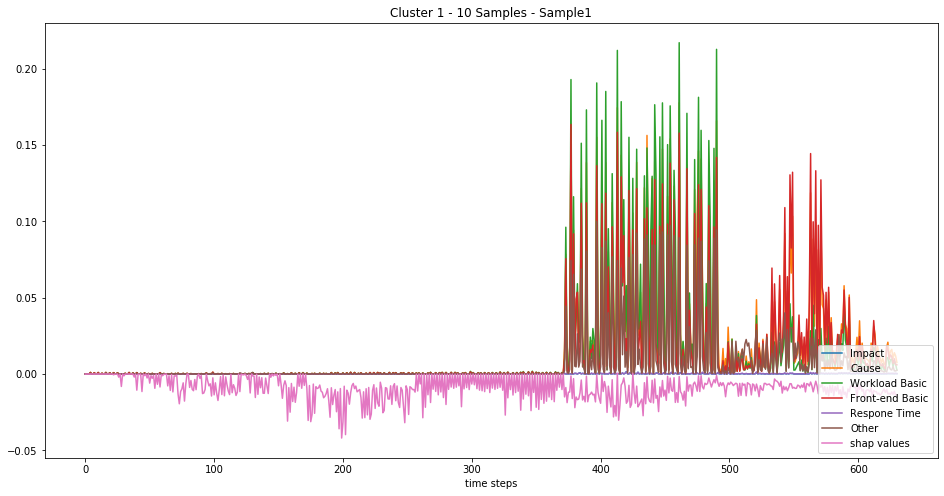

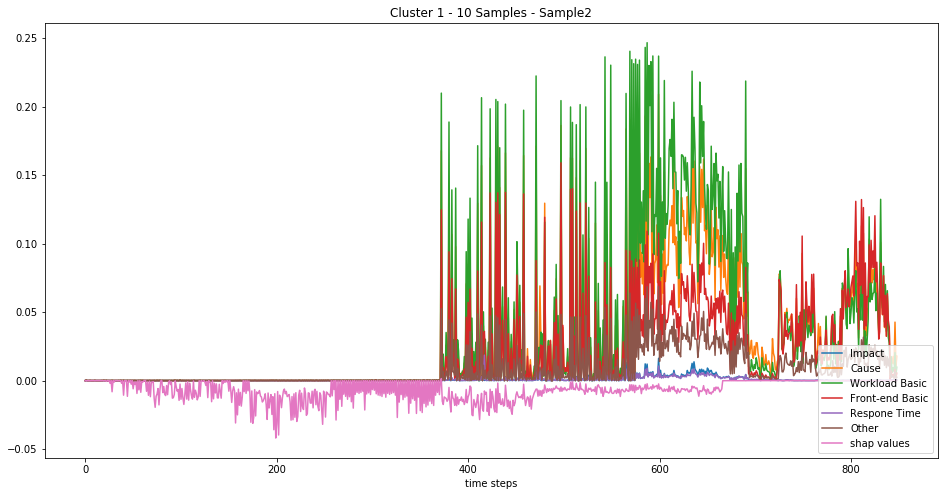

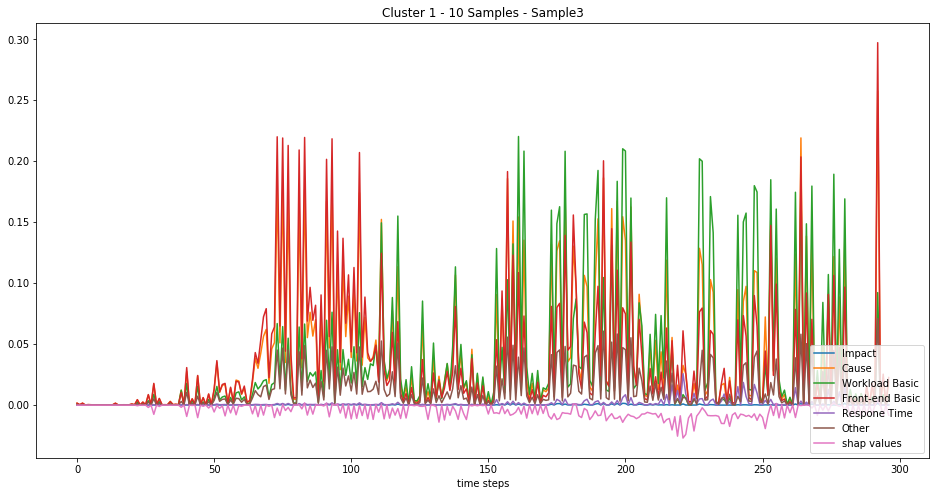

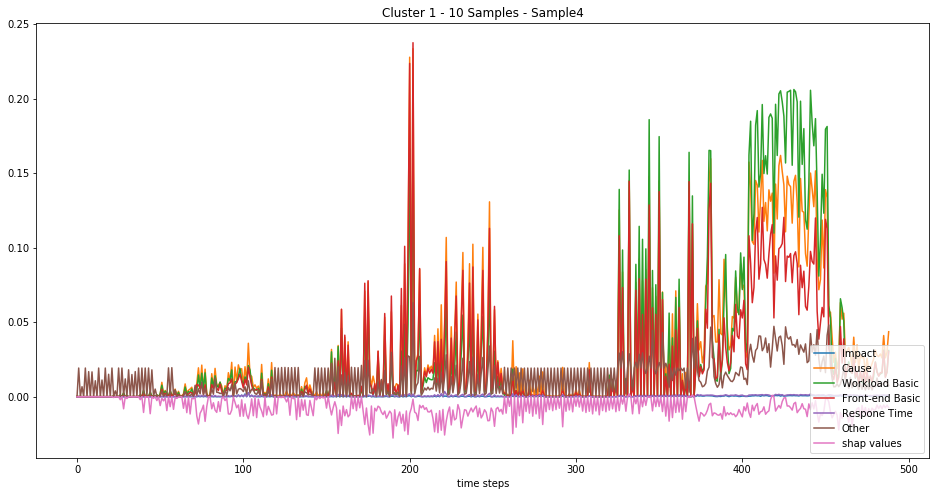

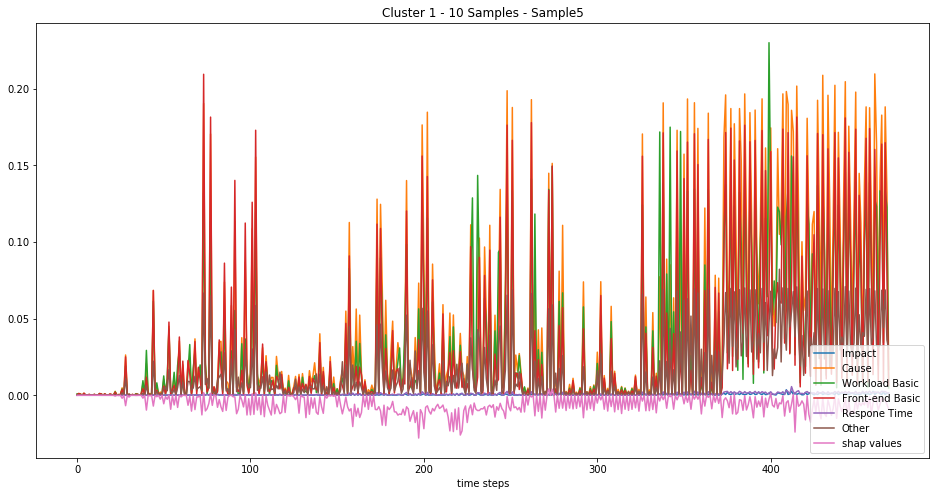

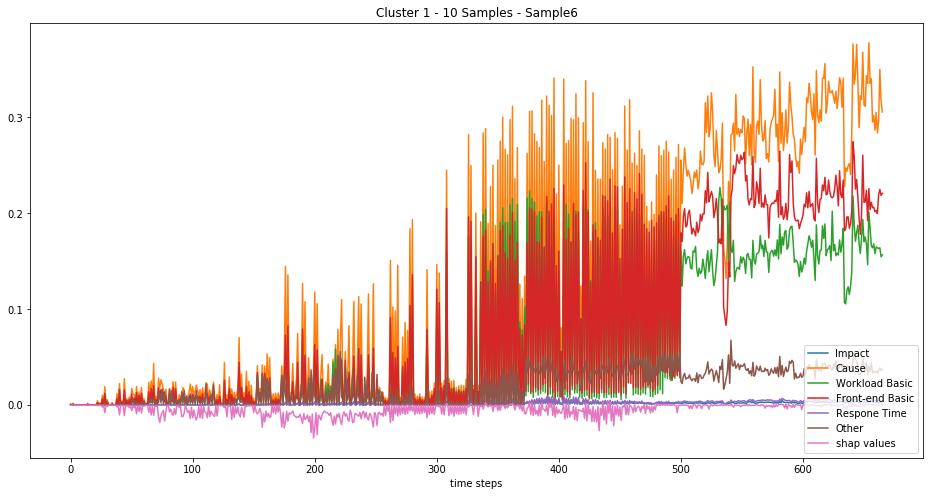

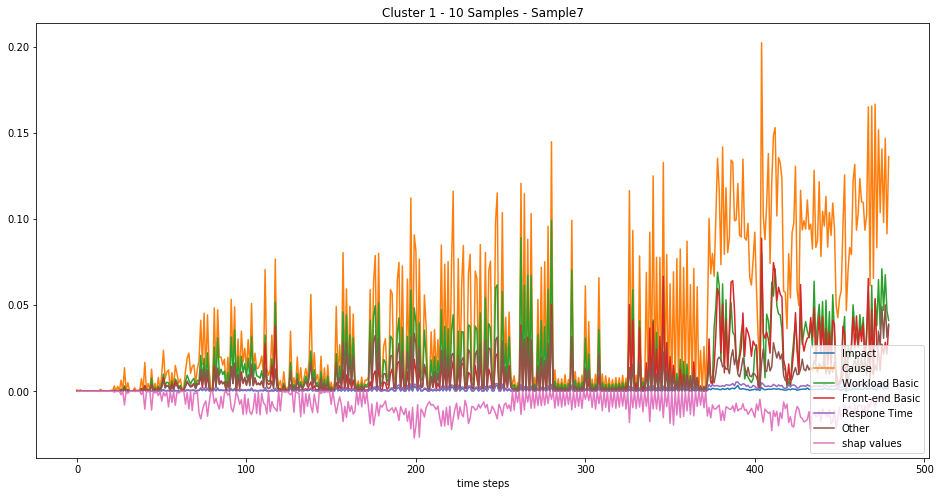

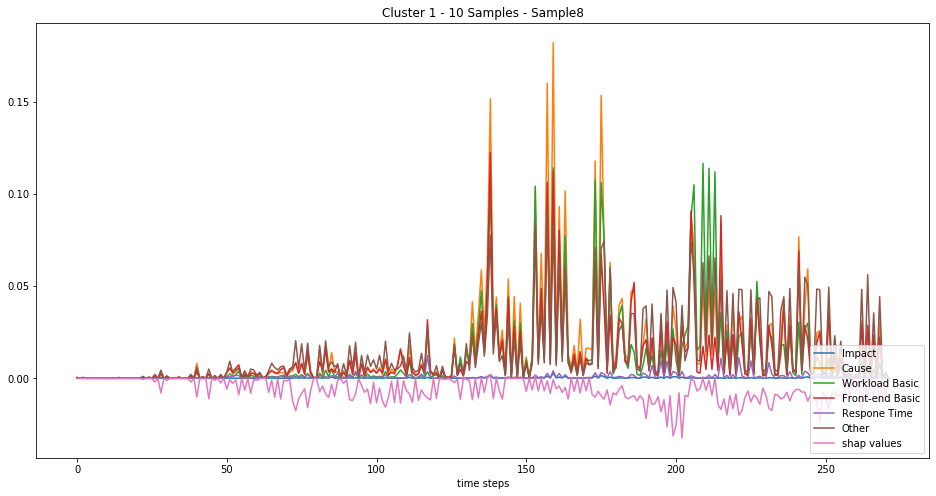

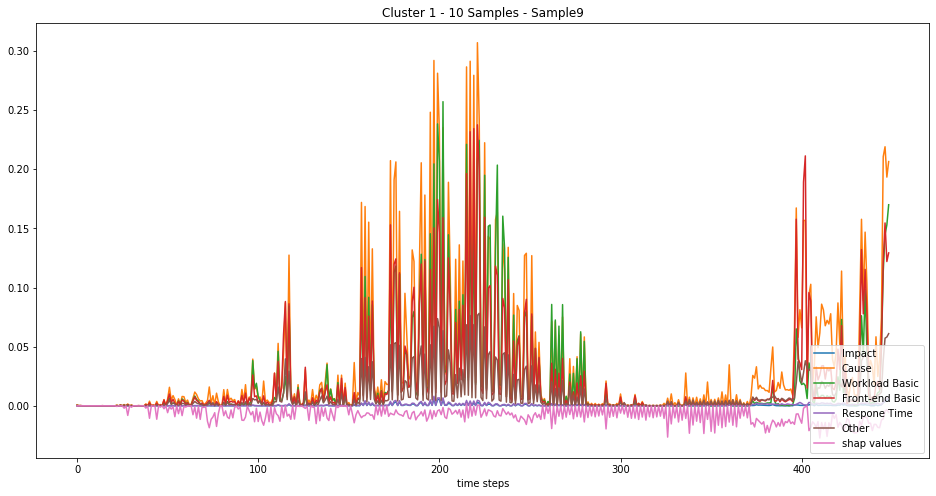

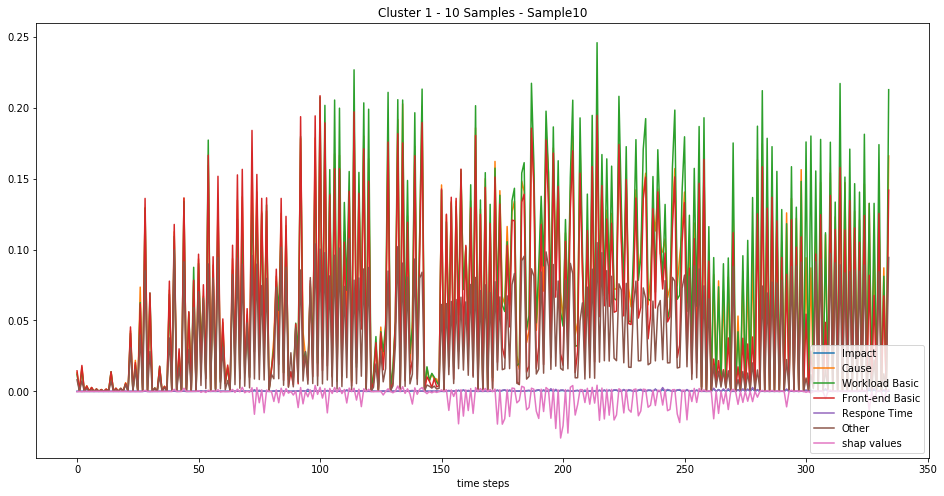

In [55]:
import matplotlib.pyplot as plt
for i in range(0,10):
    plt.figure(figsize=(16,8))
    
    plt.plot(impact_data[i],label="Impact")
    
    plt.plot(cause_data[i],label="Cause")
    
    plt.plot(workload_basic_data[i],label="Workload Basic")
    
    plt.plot(frontend_basic_data[i],label="Front-end Basic")
    
    plt.plot(response_time_data[i],label="Respone Time")
    
    plt.plot(other_data[i],label="Other")
    
    plt.plot(shap_values_allFeatures[i],label="shap values")
    
    plt.xlabel("time steps")
    
    plt.legend(loc="lower right")
    
    plt.title("Cluster 1 - 10 Samples - Sample"+str(i+1))
    
    plt.savefig('/home/sto/Plots/temporal_explanations_may03/cluster_1/cluster-1_10-samples_sample-' + str(i+1) + '.png')

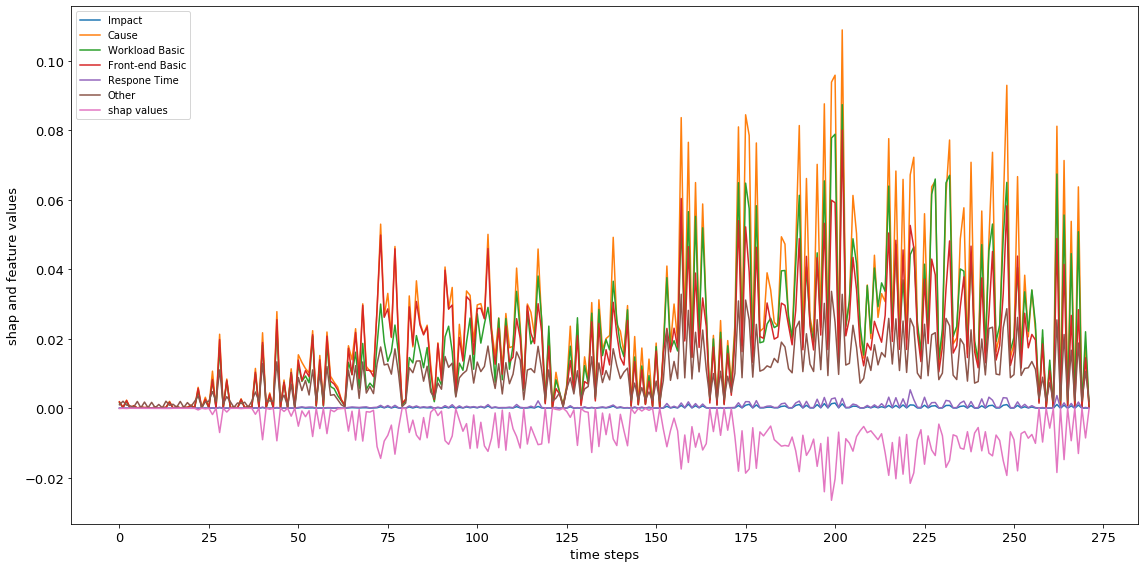

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(impact_data.mean(0),label="Impact")
plt.plot(cause_data.mean(0),label="Cause")
plt.plot(workload_basic_data.mean(0),label="Workload Basic")
plt.plot(frontend_basic_data.mean(0),label="Front-end Basic")
plt.plot(response_time_data.mean(0),label="Respone Time")
plt.plot(other_data.mean(0),label="Other")
plt.plot(shap_values_allFeatures.mean(0),label="shap values")
plt.xlabel("time steps", fontsize=13)

plt.ylabel("shap and feature values",fontsize=13)

plt.rc('xtick', labelsize=13)

plt.rc('ytick', labelsize=13) 

plt.xticks(numpy.arange(0, 280, 25),fontsize=13)

plt.tight_layout()

plt.legend(loc="upper left")
plt.savefig('/home/sto/Plots/temporal_explanations_may03/cluster_1/goodONE.png')

# Zero Buffer Credit Timer weighted down more